## Calculate the gas exchange rates 
- Uses values from the oxygen/co2 sensors from the reactor system in/out-gas

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ConstantKernel
import threadpoolctl

max_processes = 25
threadpoolctl.threadpool_limits(limits=max_processes)

Uses Gaussian process regressor to fit gas concentrations. This function plots ht eprior and posterior after fitting

In [2]:
def plot_gpr_samples(gpr_model, n_samples, ax,lims=None, X=None):
    """Plot samples drawn from the Gaussian process model.

    If the Gaussian process model is not trained then the drawn samples are
    drawn from the prior distribution. Otherwise, the samples are drawn from
    the posterior distribution. Be aware that a sample here corresponds to a
    function.

    Parameters
    ----------
    gpr_model : `GaussianProcessRegressor`
        A :class:`~sklearn.gaussian_process.GaussianProcessRegressor` model.
    n_samples : int
        The number of samples to draw from the Gaussian process distribution.
    ax : matplotlib axis
        The matplotlib axis where to plot the samples.
    """
    if not isinstance(X, np.ndarray):
        X = gpr_model.X_train_.reshape(-1, 1)

    y_mean, y_std = gpr_model.predict(X, return_std=True)
    y_samples = gpr_model.sample_y(X, n_samples)

    for idx, single_prior in enumerate(y_samples.T):
        ax.plot(
            X.flatten(),
            single_prior,
            linestyle="--",
            alpha=0.7,
            label=f"Sampled function #{idx + 1}",
        )
    ax.plot(X.flatten(), y_mean, color="black", label="Mean")
    ax.fill_between(
        X.flatten(),
        y_mean - y_std,
        y_mean + y_std,
        alpha=0.5,
        color="black",
        label=r"$\pm$ 1 std. dev.",
    )
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    if lims:
        ax.set_ylim(lims)
    else:
        ax.set_ylim([-0.01, 0.01])
    
    return y_mean, y_std

In [3]:
def calculate_OUR_CPR(df):
    co2_scaling = 0.0004/0.00038 # / (df.iloc[2:10,4].mean()/100)
    o2_scaling = 21/20.65 # 0.21 / (df.iloc[2:10,5].mean()/100)
    
    df["mol O2 in"] = df["F.PV [L/h]"]/24.07 * 0.21
    df["mol O2 out"] = df["F.Out [L/h]"]/24.07 * o2_scaling * df["XO2.Out [%]"]/100
    df["OUR"] = df["mol O2 in"] -  df["mol O2 out"]
    
    df["mol CO2 in"] = df["F.PV [L/h]"]/24.07 *0.0004
    df["mol CO2 out"] = df["F.Out [L/h]"]/24.07 * co2_scaling * df["XCO2.Out [%]"]/100
    df["CPR"] = df["mol CO2 out"] -  df["mol CO2 in"]
    


In [4]:
c023 = pd.read_excel(f"../data/RetentostatGas.xlsx", sheet_name="C023")
c023["Cultivation"] = "C023"
c024 = pd.read_excel(f"../data/RetentostatGas.xlsx", sheet_name="C024")
c024["Cultivation"] = "C024"
c030 = pd.read_excel(f"../data/RetentostatGas.xlsx", sheet_name="C030")
c030["Cultivation"] = "C030"

calculate_OUR_CPR(c023)
calculate_OUR_CPR(c024)
calculate_OUR_CPR(c030)

df = pd.concat([c023,c024,c030])
df["Time in retentostat [d]"] = df["Time in retentostat [d]"].round(2)

df = df[~df["Time in retentostat [d]"].isna()]
df = df[df["Time in retentostat [d]"] < 28]
df["Time in retentostat [h]"] = df["Time in retentostat [d]"]*24
df["Time in retentostat [h]"] = df["Time in retentostat [h]"].apply(lambda x: round(x)/2) 

df.sort_values(by="Time in retentostat [d]", inplace=True)

df = df[(df["OUR"] > 0.00)&(df["OUR"] < 0.02)]
df = df[(df["CPR"] > 0.00)&(df["CPR"] < 0.01)]

sp_list = [0.0, 22.0, 44.5, 141.0, 189.5, 237.0, 333.0, 404.5, 476.5, 572.5, 669.0]
sp_name = [f"R{i}" for i in np.arange(11)]
sp_name[0] = "SS"

<AxesSubplot:xlabel='Time in retentostat [d]', ylabel='XCO2.Out [%]'>

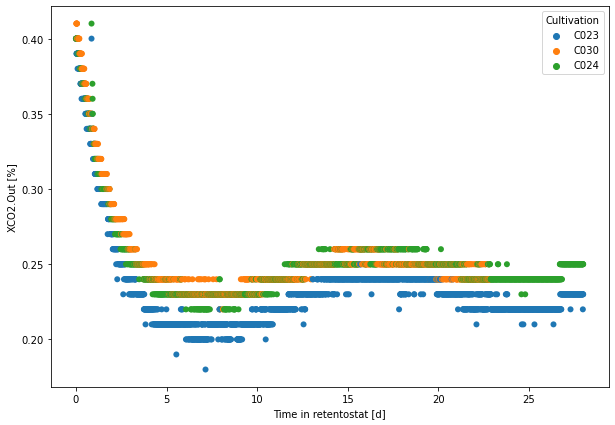

In [5]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(10,7))
sns.scatterplot(data=df,x="Time in retentostat [d]", y="XCO2.Out [%]", hue="Cultivation",ec=None)

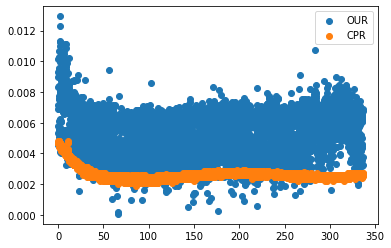

In [6]:
fig, ax = plt.subplots()
ax.scatter(df["Time in retentostat [h]"], df["OUR"], label="OUR")
ax.scatter(df["Time in retentostat [h]"], df["CPR"], label="CPR")
ax.legend()

Import regression data to use integrated biomass concnetrations for specific rate calculation

In [7]:

retentostat = pd.read_csv(f"../results/dataframes/cultivation_data/RegressionDynamicRetentostat.csv")
retentostat["Time d"]=retentostat["Time d"].round(2)


Values are calculate per individual reactor/replicate. Decided to restrict the lower bound on the white noise, assuming that any cycling is due to measurement error as opposed to something worth "fitting"

/home/users/bcoltman/.conda/envs/memo3.7/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified lower bound 0.005. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning,
/home/users/bcoltman/.conda/envs/memo3.7/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-07. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning,


0.0707**2 * RBF(length_scale=12.7) + WhiteKernel(noise_level=1e-07)


/home/users/bcoltman/.conda/envs/memo3.7/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified lower bound 0.005. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning,
/home/users/bcoltman/.conda/envs/memo3.7/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-07. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning,


0.0707**2 * RBF(length_scale=13.2) + WhiteKernel(noise_level=1e-07)


/home/users/bcoltman/.conda/envs/memo3.7/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified lower bound 0.005. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning,
/home/users/bcoltman/.conda/envs/memo3.7/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-07. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning,


0.0707**2 * RBF(length_scale=13.1) + WhiteKernel(noise_level=1e-07)


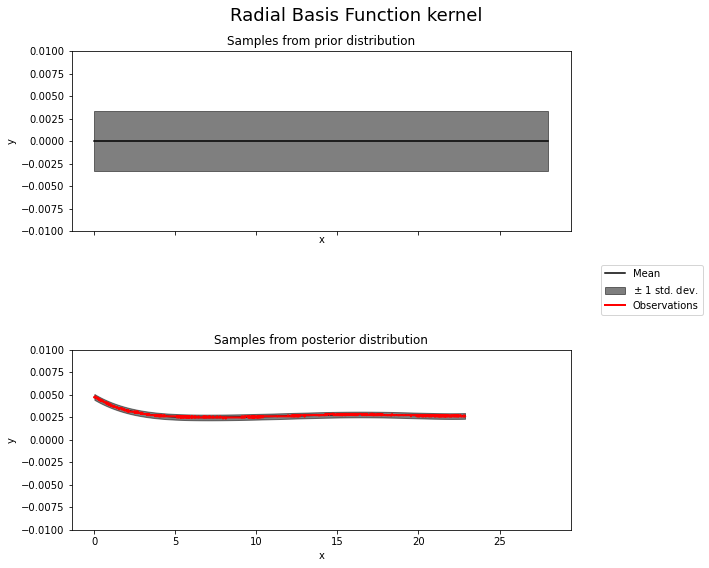

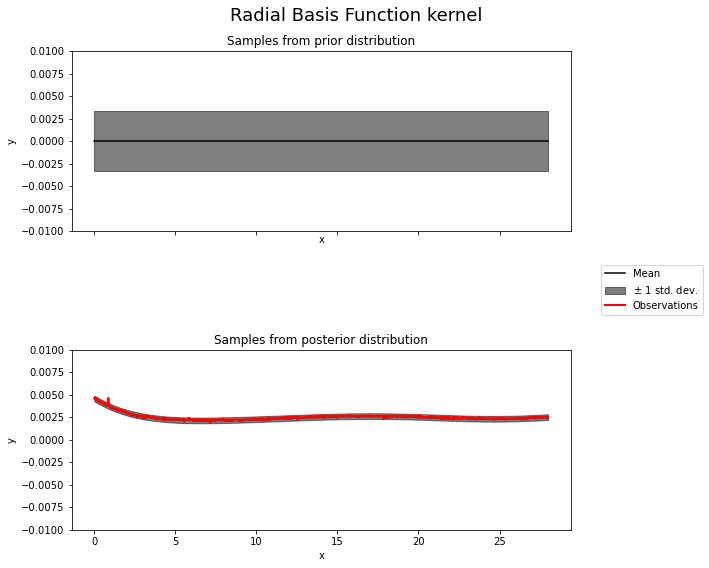

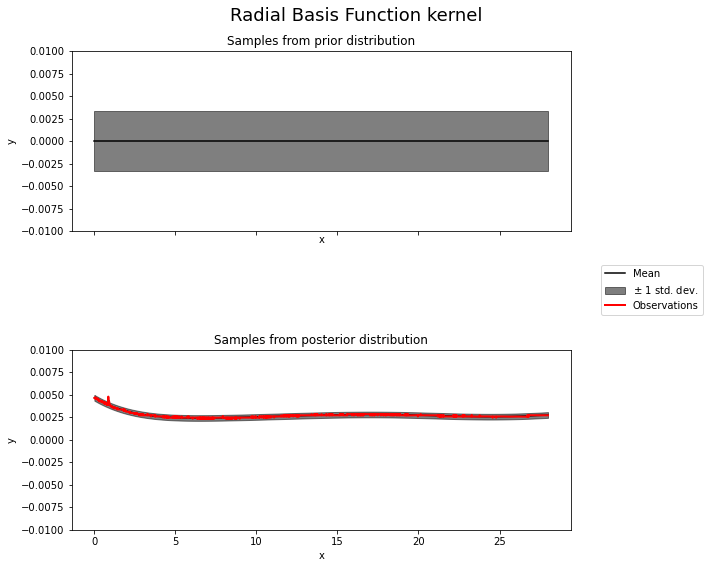

In [8]:

for cul in ["C030", "C023", "C024"]:
    temp_df = df[df["Cultivation"] == cul]
    X_train = temp_df["Time in retentostat [d]"].values.reshape(-1,1)
    y_train = temp_df["CPR"].values
    n_samples = 0

    kernel = ConstantKernel(1e-5, (0.005, 1)) * RBF(length_scale=1e1, length_scale_bounds=(1, 2e1)) + WhiteKernel(noise_level=1e-6, noise_level_bounds=(1e-7, 1e1))

    gpr = GaussianProcessRegressor(kernel=kernel, random_state=0,alpha=0)

    fig, axs = plt.subplots(nrows=2, sharex=True, sharey=True, figsize=(10, 8))


    # plot prior
    plot_gpr_samples(gpr, n_samples=n_samples, ax=axs[0], X=np.linspace(0, 28, 300).reshape(-1,1))
    axs[0].set_title("Samples from prior distribution")

    # # plot posterior
    gpr.fit(X_train, y_train)
    
    y_pred, y_std = plot_gpr_samples(gpr, n_samples=n_samples, ax=axs[1])
    axs[1].plot(X_train[:, 0], y_train, color="red", label="Observations", lw=2, alpha=1)

    axs[1].legend(bbox_to_anchor=(1.05, 1.5), loc="upper left")
    axs[1].set_title("Samples from posterior distribution")

    fig.suptitle("Radial Basis Function kernel", fontsize=18)
    plt.tight_layout()
    print(gpr.kernel_)
    
    max_x_train = max(X_train)
    X = retentostat[retentostat["Cultivation"] == cul]["Time d"].values
    X = X[X<=max_x_train].reshape(-1,1)
    
    y_pred, y_std = gpr.predict(X, return_std=True)
    retentostat.loc[(retentostat["Cultivation"] == cul)&(retentostat["Time d"].isin(X.flatten())),["CPR", "CPR_Std"]] = np.hstack([y_pred.reshape(-1,1), y_std.reshape(-1,1)])

/home/users/bcoltman/.conda/envs/memo3.7/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified lower bound 5. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning,
/home/users/bcoltman/.conda/envs/memo3.7/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning,


0.00461**2 * RBF(length_scale=5) + WhiteKernel(noise_level=1e-06)
0.0214**2 * RBF(length_scale=6.83) + WhiteKernel(noise_level=1.29e-06)


/home/users/bcoltman/.conda/envs/memo3.7/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning,


0.00613**2 * RBF(length_scale=6.44) + WhiteKernel(noise_level=1e-06)


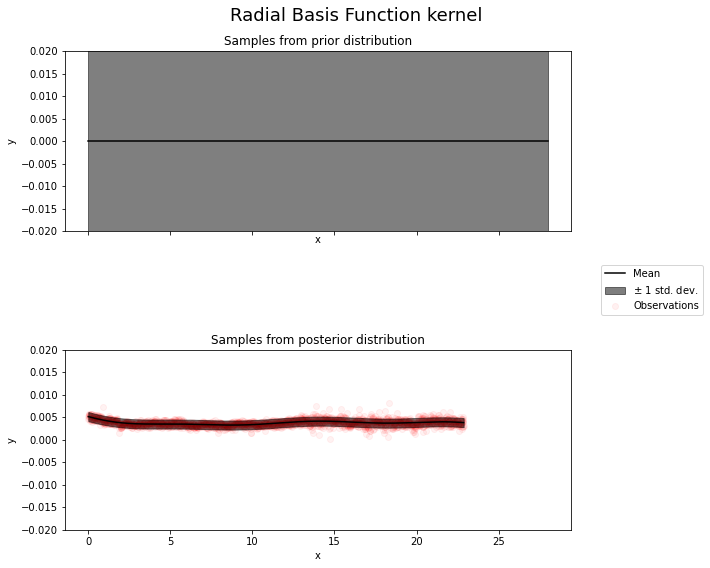

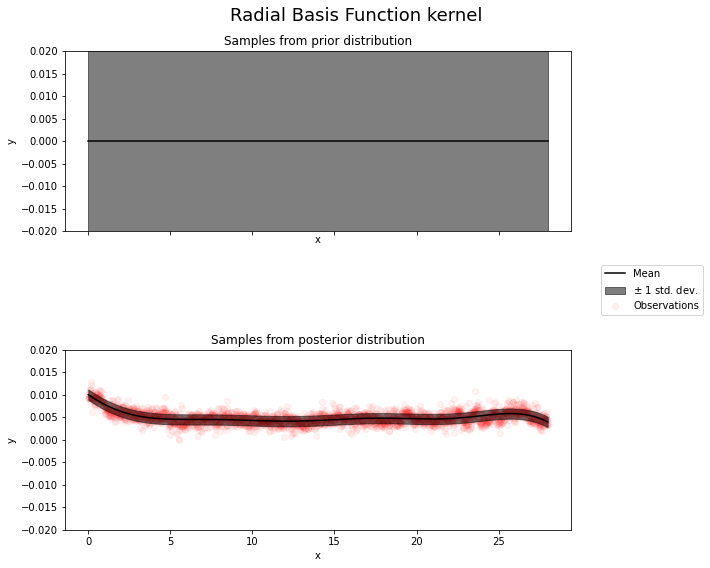

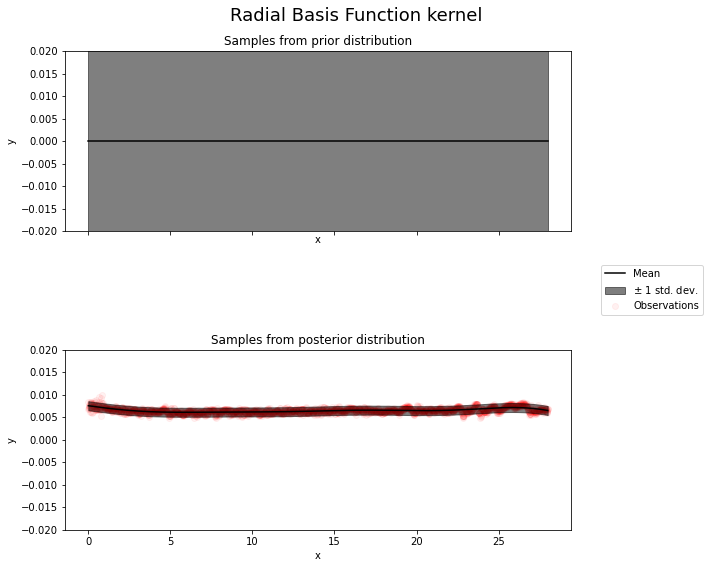

In [9]:

for cul in ["C030" ,"C023", "C024"]:
    temp_df = df[df["Cultivation"] == cul]
    X_train = temp_df["Time in retentostat [d]"].values.reshape(-1,1)
    y_train = temp_df["OUR"].values
    n_samples = 0

    kernel = ConstantKernel(1e-3, (1e-10, 1e5)) * RBF(length_scale=1e1, length_scale_bounds=(5, 90)) + WhiteKernel(noise_level=1e1, noise_level_bounds=(1e-6, 1e6))
    gpr = GaussianProcessRegressor(kernel=kernel, random_state=0, alpha=0)

    fig, axs = plt.subplots(nrows=2, sharex=True, sharey=True, figsize=(10, 8))

    # plot prior
    plot_gpr_samples(gpr, n_samples=n_samples, ax=axs[0], X=np.linspace(0, 28, 300).reshape(-1,1), lims=[-0.02,0.02])
    axs[0].set_title("Samples from prior distribution")

    # # plot posterior
    gpr.fit(X_train, y_train)
    plot_gpr_samples(gpr, n_samples=n_samples, ax=axs[1], lims=[-0.02,0.02])
    axs[1].scatter(X_train[:, 0], y_train, color="red", zorder=0, label="Observations", alpha=0.05)
    

    axs[1].legend(bbox_to_anchor=(1.05, 1.5), loc="upper left")
    axs[1].set_title("Samples from posterior distribution")

    fig.suptitle("Radial Basis Function kernel", fontsize=18)
    plt.tight_layout()
    print(gpr.kernel_)
    
    max_x_train = max(X_train)
    X = retentostat[retentostat["Cultivation"] == cul]["Time d"].values
    X = X[X<=max_x_train].reshape(-1,1)
    
    y_pred, y_std = gpr.predict(X, return_std=True)
    retentostat.loc[(retentostat["Cultivation"] == cul)&(retentostat["Time d"].isin(X.flatten())),["OUR", "OUR_Std"]] = np.hstack([y_pred.reshape(-1,1), y_std.reshape(-1,1)])

In [10]:
sps = retentostat[retentostat["Time h"].isin([round(x*2)/2 for x in sp_list])].copy()
sps.loc[:,"Sample Point"] = sp_name*3

chemo = pd.read_csv("../data/FermDataChemo.csv")
sps.set_index(["Cultivation", "Sample Point"],inplace=True)
chemo.set_index(["Cultivation", "Sample Point"],inplace=True)
FermData = chemo.combine_first(sps)
# FermData.to_csv("../data/FermDataDynamic.csv")
FermData.to_csv("../results/dataframes/cultivation_data/FermDataDynamic.csv")

Text(0.5, 1.0, 'OUR')

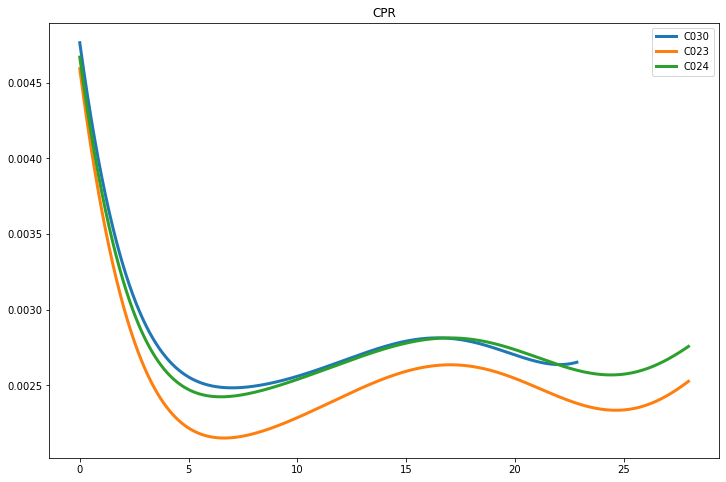

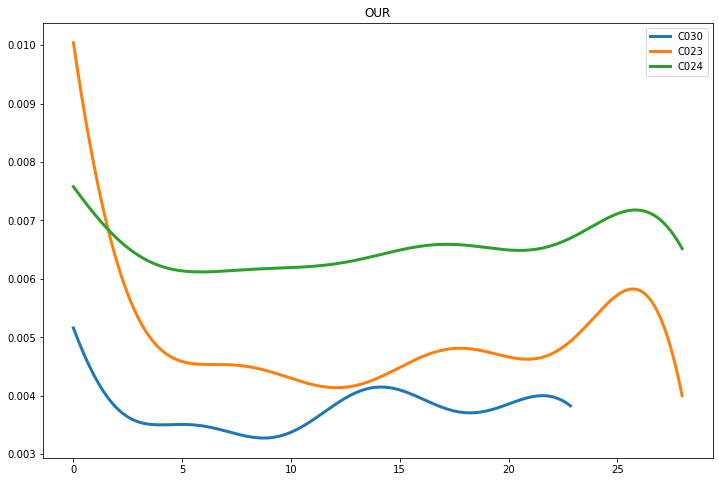

In [11]:
fig, ax = plt.subplots(1, figsize=(12,8))
for cul in ["C030", "C023", "C024"]:
    ax.plot(retentostat[retentostat["Cultivation"] == cul]["Time d"], retentostat[retentostat["Cultivation"] == cul]["CPR"],lw=3,label=cul)
ax.legend()
ax.set_title("CPR")

fig, ax = plt.subplots(1, figsize=(12,8))
for cul in ["C030", "C023", "C024"]:
    ax.plot(retentostat[retentostat["Cultivation"] == cul]["Time d"], retentostat[retentostat["Cultivation"] == cul]["OUR"],lw=3,label=cul)
ax.legend()
ax.set_title("OUR")